# Приоретизация гипотез, проведение А/В теста и анализ результатов для интернет-магазина

## Описание данных

В файле `hypothesis.csv` девять гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`.

**Задача**

 - Применить фреймворки ICE и RICE для приоритизации гипотез.
 - Проанализировать результаты AB теста.
 - 
## Изучение и предобработка данных

In [29]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
import plotly.express as px

In [3]:
# загрузка данных
hypothesis = pd.read_csv('datasets/hypothesis.csv')
orders = pd.read_csv('datasets/orders.csv')
visitors = pd.read_csv('datasets/visitors.csv')

In [4]:
d_frames = {'hypothesis' : hypothesis, 'orders' : orders, 'visitors' : visitors}
for a, i in d_frames.items():
    print(f'Таблица {a}, количество дубликатов {i.duplicated().sum()}')
    display(i.info())

Таблица hypothesis, количество дубликатов 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


None

Таблица orders, количество дубликатов 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Таблица visitors, количество дубликатов 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [5]:
dframes = [orders, visitors]
# перевод названий колонок к нижнему регистру
for df in dframes:
    df.columns = [column.lower() for column in df.columns]

# названия колонок к snake_case
orders.rename(columns={'transactionid': 'transaction_id', 'visitorid': 'visitor_id'}, inplace=True)

# приведение к типу даты колонок с датами
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d').dt.date
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d').dt.date
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

# проверка совпадения дат начала и окончания теста и типов данных. проверка пропущеных значений
print('visitors \nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()), visitors.dtypes)
print('\nПропущенные значения в таблице visitors:')
print(visitors.isnull().sum())
print('orders \nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()), orders.dtypes)
print('\nПропущенные значения в таблице orders:')
print(orders.isnull().sum())

visitors 
Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00
 date        datetime64[ns]
group               object
visitors             int64
dtype: object

Пропущенные значения в таблице visitors:
date        0
group       0
visitors    0
dtype: int64
orders 
Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00
 transaction_id             int64
visitor_id                 int64
date              datetime64[ns]
revenue                    int64
group                     object
dtype: object

Пропущенные значения в таблице orders:
transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64


In [6]:
# проверка пользователей попавших в обе группы
d_users = orders.groupby(['visitor_id']).agg({'group': 'nunique', 'transaction_id': 'count', 'revenue': 'sum'}).reset_index()
print(f'Продублированых пользователей: {d_users[d_users.group != 1]["visitor_id"].count()}')


Продублированых пользователей: 58


In [7]:
d_users = orders.groupby(['visitor_id']).agg({'group': 'nunique', 'transaction_id': 'count', 'revenue': 'sum'}).reset_index()
duplicated_users = d_users[d_users['group'] > 1]['visitor_id']

# удалим их из orders
orders = orders[~orders['visitor_id'].isin(duplicated_users)]

# обновим d_users после изменений
d_users = orders.groupby(['visitor_id']).agg({'group': 'nunique', 'transaction_id': 'count', 'revenue': 'sum'}).reset_index()

# проверим количество продублированных пользователей
print(f'Продублированных пользователей после удаления: {d_users[d_users.group != 1]["visitor_id"].count()}')


Продублированных пользователей после удаления: 0


Даты совпадают и приведены к нужному типу. Названия колонок приведены к нижнему регистру.

## Приоритизация гипотез

In [8]:
# подсчет и добавление столбца ICE
hypothesis['ice'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

# подсчет и добавление столбца RICE
hypothesis['rice'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [10]:
pd.set_option('max_colwidth', 200)
hypothesis['ice'] = hypothesis['ice'].round(2)

# сортируем в порядке убывания по столбцу ICE
hypothesis.sort_values(by='ice', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


In [11]:
# сортируем в порядке убывания по столбцу RICE
hypothesis.sort_values(by='rice', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


При использовании RICE вместо ICE приоритет гипотез изменяется из-за включения параметра "Reach". Гипотезы с высоким "Reach" получают более высокий приоритет, что отражает важность охвата пользователей при принятии решения о приоритете гипотез.

Таким образом:
1. Гипотеза №7 (Добавить форму подписки...):
 - При использовании ICE была на 3-м месте.
 - При использовании RICE стала на 1-м месте из-за высокого параметра "Reach" (охват).
2. Гипотеза №2 (Добавить блоки рекомендаций...):
 - При использовании ICE была на 5-м месте.
 - При использовании RICE стала на 2-м месте, также из-за высокого параметра "Reach".
3. Гипотеза №0 (Добавить два новых канала...):
 - При использовании ICE была на 2-м месте.
 - При использовании RICE осталась на 3-м месте, потому что её высокий "Impact" компенсируется более низким "Reach".
4. Гипотеза №6 (Показать на главной странице баннеры...):
 - При использовании ICE была на 4-м месте.
 - При использовании RICE осталась на 4-м месте с небольшим изменением в приоритете.

**Вывод: в приоритете гипотезы 7, 2, 0.**

## Анализ А/В теста.

### График кумулятивной выручки по группам.

#### Подготовка к построению графика. Создание массивов, агрегация данных

In [12]:
# создание уникальных пар значений ДАТА:ГРУППА ТЕСТА
dateGroup = orders[['date', 'group']].drop_duplicates()

# кумулятивные значения о заказах по дням 
ordersAgg = dateGroup.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date': 'max', 'group': 'max', 'transaction_id': pd.Series.nunique, 'visitor_id': pd.Series.nunique,
     'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

# кумулятивные значения о посетителях по дням 
visitorsAgg = dateGroup.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])

# объединение данных
cumulativeData = ordersAgg.merge(visitorsAgg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# разбивка по группам
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

##### График кумулятивной выручки по группам

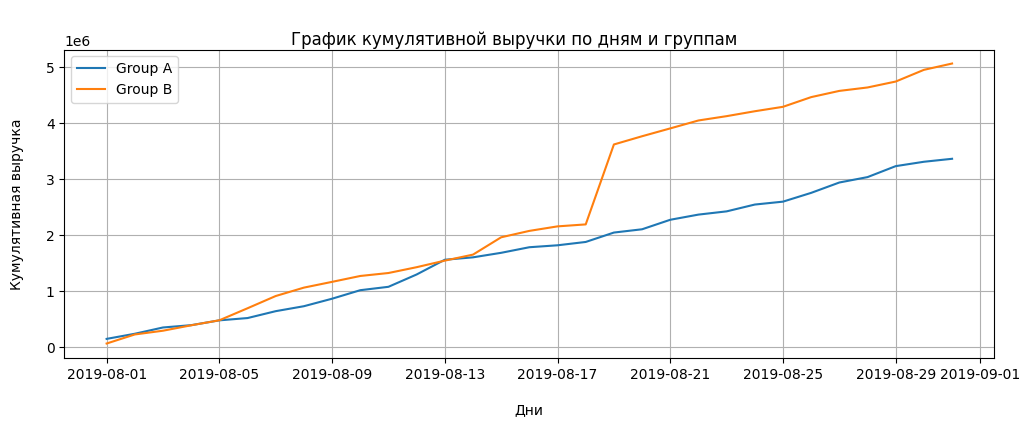

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
fig.suptitle('\nГрафик кумулятивной выручки по дням и группам')

ax.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Group A')
ax.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Group B')

ax.legend(loc='upper left')
ax.set_ylabel('Кумулятивная выручка\n')
ax.set_xlabel('\nДни')
ax.grid(True)

**Вывод**

1. Увеличение выручки на протяжении теста.
2. Резкий скачок в интервале между 17 и 21 августа в группе В. Может быть обусловлен:
 - появлением дорогих заказов,
 - увеличением числа заказов.

### График кумулятивного среднего чека по группам


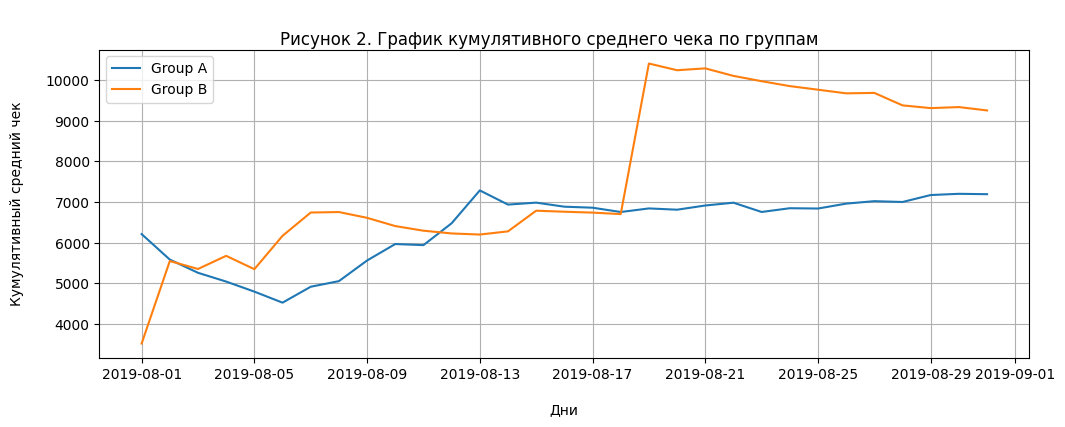

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
fig.suptitle('\nРисунок 2. График кумулятивного среднего чека по группам')

ax.plot(cumulativeRevenueA['date'], 
        cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'],
        label='Group A')
ax.plot(cumulativeRevenueB['date'], 
        cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], 
        label='Group B')

ax.legend(loc='upper left')
ax.set_ylabel('Кумулятивный средний чек\n')
ax.set_xlabel('\nДни')
ax.grid(True)

**Вывод**

1. К концу анализируемого периода, кумулятивный средний чек группы A выходит на стабильный уровень.
2. В группе B, напротив, наблюдается недавнее снижение кумулятивного среднего чека к концу анализируемого периода. Это может быть обусловлено влиянием крупных заказов, которые могли попасть в группу B.

### График относительного изменения кумулятивного среднего чека группы B к группе A


Подготовка данных

In [15]:
# объединение
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Построение графика

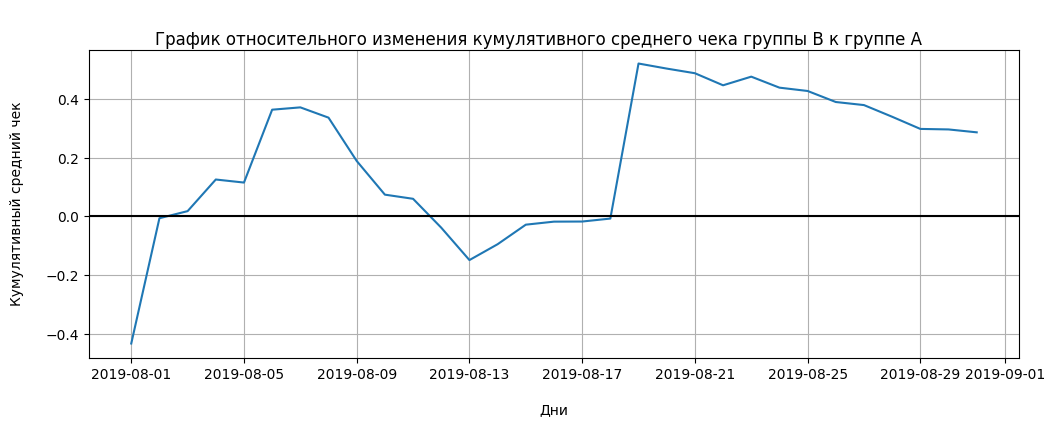

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
fig.suptitle('\nГрафик относительного изменения кумулятивного среднего чека группы B к группе A')

ax.plot(mergedCumulativeRevenue['date'], 
        (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) / 
        (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='-')

ax.set_ylabel('Кумулятивный средний чек\n')
ax.set_xlabel('\nДни')
ax.grid(True)

**Вывод**

Неравноменость графика говорит о наличии выбросов в данных

### График кумулятивного среднего количества заказов на посетителя по группам

In [17]:
# подсчет среднего
cumulativeData['avg_orders_per_visitor'] = cumulativeData['orders'] / cumulativeData['visitors']

# разбивка по группам
cumulativeAvgOrdersA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'avg_orders_per_visitor']]
cumulativeAvgOrdersB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'avg_orders_per_visitor']]


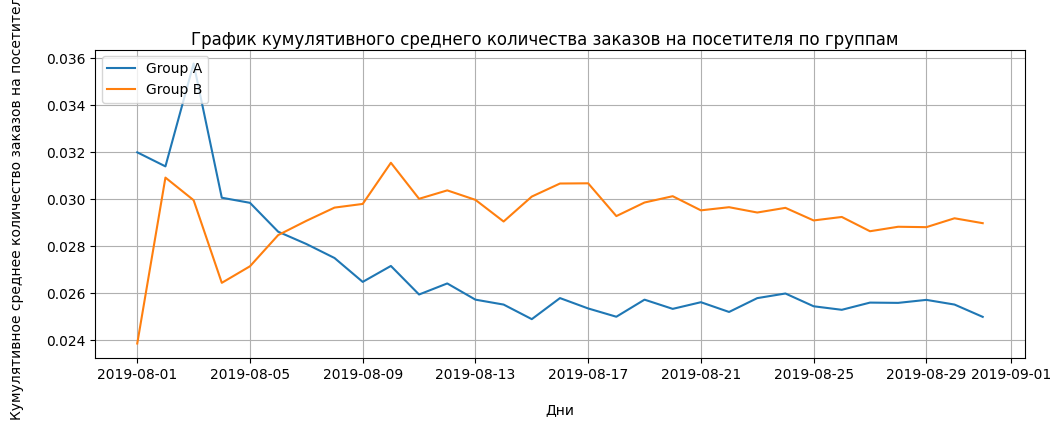

In [18]:
# построение графика
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle('\nГрафик кумулятивного среднего количества заказов на посетителя по группам')

ax.plot(cumulativeAvgOrdersA['date'], cumulativeAvgOrdersA['avg_orders_per_visitor'], label='Group A')
ax.plot(cumulativeAvgOrdersB['date'], cumulativeAvgOrdersB['avg_orders_per_visitor'], label='Group B')

ax.legend(loc='upper left')
ax.set_ylabel('Кумулятивное среднее количество заказов на посетителя\n')
ax.set_xlabel('\nДни')
ax.grid(True)
plt.show()



**Вывод**

Показатель среднего количества заказов группы В сразу выросла и стабилизировалась на более высоком уровне, в то время как группа А начала с более высоких значений, но постепенно просела и зафиксировалась на более низком уровне. Таким образом, графики показателей среднего количества заказов групп А и В обладают симметрией, но показатели группы B стабильно превосходят группу A. 

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.


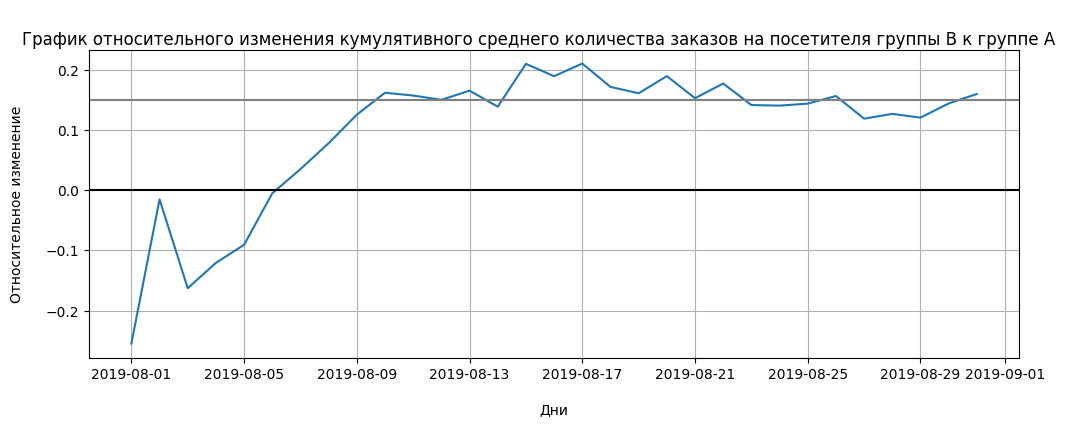

In [19]:
# объединение данных
mergedCumulativeAvgOrders = cumulativeAvgOrdersA.merge(cumulativeAvgOrdersB, on='date', suffixes=['A', 'B'])

# построение графика
fig, ax = plt.subplots(figsize=(12,4))
fig.suptitle('\nГрафик относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')

ax.plot(mergedCumulativeAvgOrders['date'], 
        mergedCumulativeAvgOrders['avg_orders_per_visitorB'] / mergedCumulativeAvgOrders['avg_orders_per_visitorA'] - 1)
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=0.15, color='grey', linestyle='-')
ax.set_ylabel('Относительное изменение\n')
ax.set_xlabel('\nДни')
ax.grid(True)
plt.show()


**Вывод**

1. С начала теста группы A и B были примерно на одном уровне, однако затем группа B резко вырвалась вперед и установила стабильное преимущество над группой A.
2. После вырывания вперед группа B стабильно удерживает лидерство в кумулятивном среднем количестве заказов на посетителя. На протяжении всего теста группа A проигрывает группе B, и разрыв между ними стабилизировался.
3. Хотя группа B незначительно проседает под конец теста, общая картина свидетельствует о стабильном лучшем показателе группы B по сравнению с группой A.

### Точечный график количества заказов по пользователям

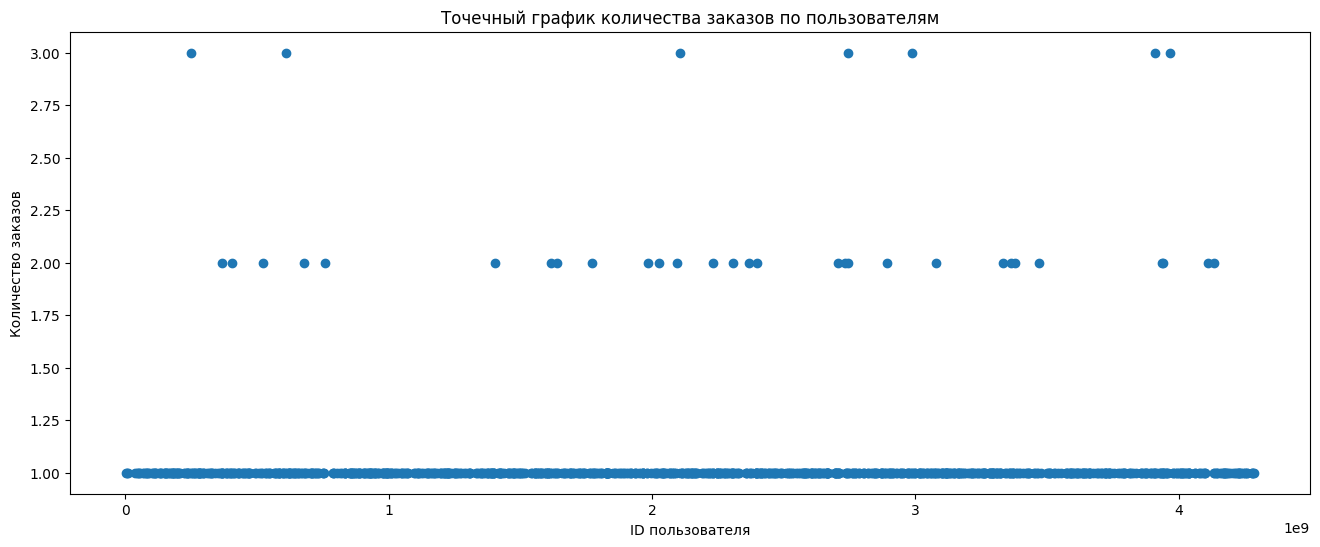

In [20]:
# подсчет количества заказов по пользователям
orders_per_user = orders.groupby('visitor_id')['transaction_id'].nunique().reset_index()

# построение точечного графика
plt.figure(figsize=(16, 6))
plt.scatter(orders_per_user['visitor_id'], orders_per_user['transaction_id'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('ID пользователя')
plt.ylabel('Количество заказов')
plt.show()

**Вывод**

Пользователи в основном совершают по 1 и 2 заказа 

### Выбор границы для определения аномальных пользователей

In [24]:
# вывод decribe c нужными процентилями
orders_per_user['transaction_id'].describe(percentiles=[.95, .99])

count    973.000000
mean       1.044193
std        0.238090
min        1.000000
50%        1.000000
95%        1.000000
99%        2.000000
max        3.000000
Name: transaction_id, dtype: float64

 - 1% пользователей совершили от 4 заказов
 - 5% пользователей совешили от 2 заказов

 Пользователи совершившие 3 заказа и более, определены, как аномальные. 

### Точечный график стоимостей заказов

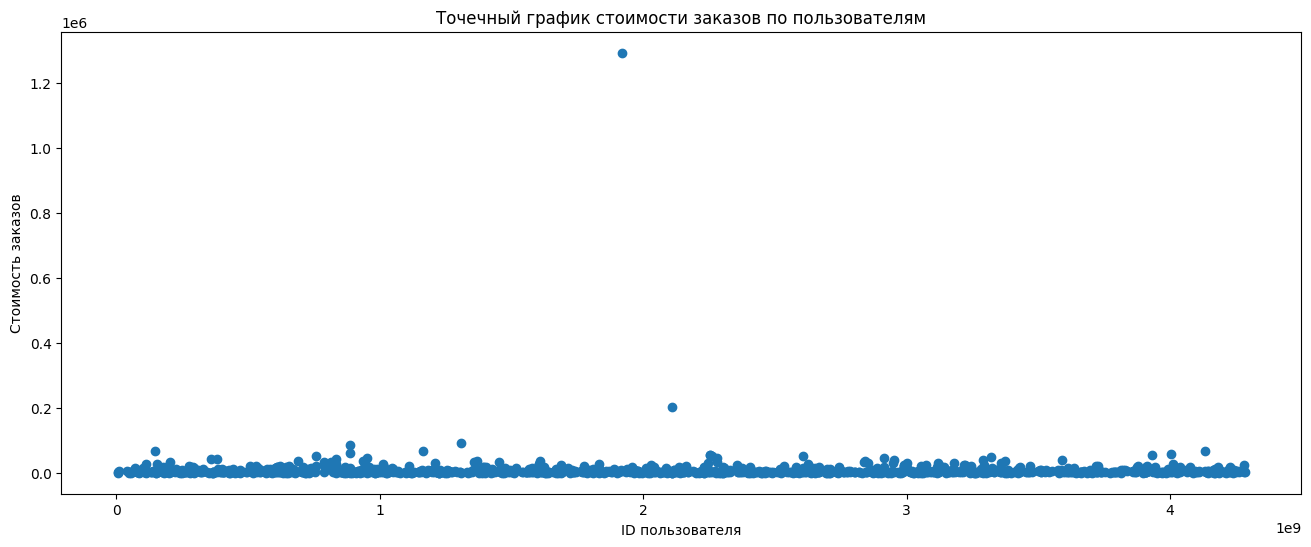

In [22]:
plt.figure(figsize=(16, 6))
plt.scatter(orders['visitor_id'], orders['revenue'])
plt.title('Точечный график стоимости заказов по пользователям')
plt.xlabel('ID пользователя')
plt.ylabel('Стоимость заказов')
plt.show()


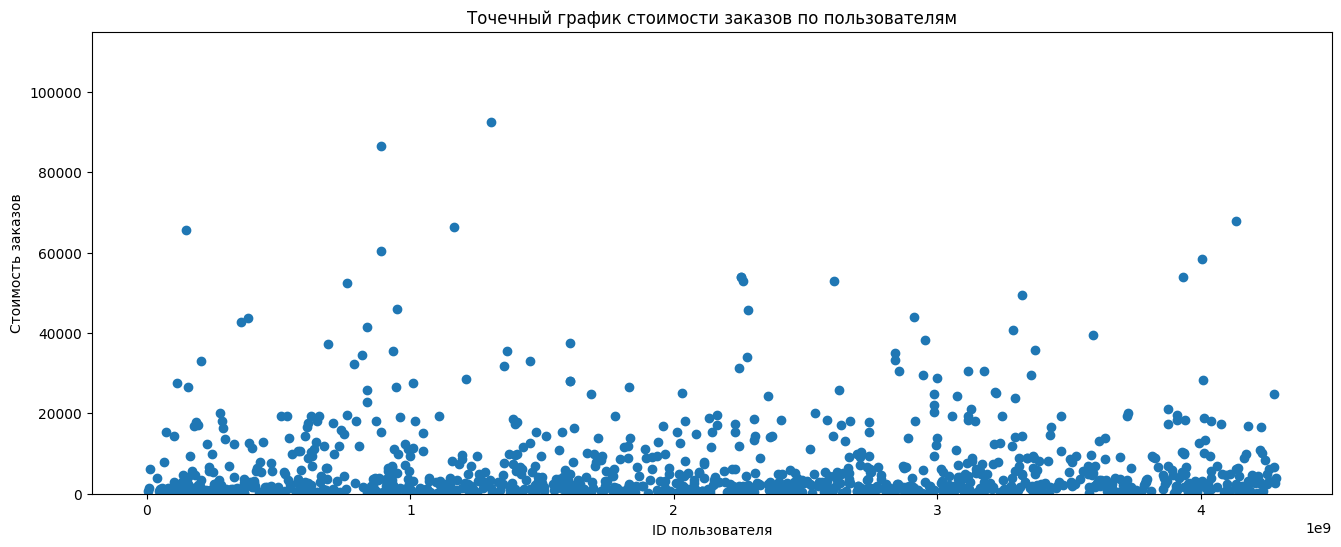

In [23]:
plt.figure(figsize=(16, 6))
plt.scatter(orders['visitor_id'], orders['revenue'])
plt.title('Точечный график стоимости заказов по пользователям')
plt.xlabel('ID пользователя')
plt.ylabel('Стоимость заказов')
plt.ylim(0, 115000)
plt.show()

### Выбор границы для определения аномальных заказов

In [27]:
# вывод decribe c нужными процентилями
pd.set_option('display.float_format', lambda x: '%.0f' % x)
orders['revenue'].describe(percentiles=[0.95, 0.99])


count      1016
mean       8301
std       42122
min          50
50%        2955
95%       26785
99%       53904
max     1294500
Name: revenue, dtype: float64

**Вывод**
5% пользователей сделали заказов от 28000, этих пользователей и будем считать аномальными

### Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

 - Нулевая гипотеза H0: статистически значимые различия в среднем количестве заказов на посетителя по "сырым" данным отсутствуют
 - Гипотеза H1: статистически значимые различия в среднем количестве заказов на посетителя по "сырым" данным есть

 Пороговое значение для определения статистической значимости **alpha = 0.05**

 Тест будет проведен по критерию Манна-Уитни, поскольку этот метод не требует нормального распределения данных и подходит для выборок небольшого объёма.

In [24]:
# функция для агрегации данных по заказам для заданной группы
def aggregate_orders_data(group):
    orders_per_users = (
        orders[orders['group']==group]
        .groupby('visitor_id', as_index=False)
        .agg({'transaction_id':'nunique'})
        .rename(columns={'transaction_id': 'orders'})
    )
    print('Кол-во покупателей в группе {}: {}'.format(group, len(orders_per_users)))
    print('Кол-во покупок в группе {}: {}'.format(group, orders_per_users['orders'].sum()))
    print('Кол-во посетителей в группе {}: {}\n'.format(group, visitors[visitors['group']==group]['visitors'].sum()))
    return orders_per_users

# функция для создания данных по пользователям, не совершившим покупки
def create_orders_by_non_purchased_users(group, orders_per_users):
    list_orders = [0] * (visitors[visitors['group']==group]['visitors'].sum() - len(orders_per_users))
    return pd.Series(data=list_orders, name='orders')

# функция для расчета относительного прироста конверсии между двумя группами
def calculate_conversion_rate(sampleA, sampleB):
    print('\n Относительное увеличение числа заказов в группе B по сравнению с группой A: {:.3f}'.format(sampleB.mean()/sampleA.mean()-1))

# функция для проведения теста Манна-Уитни и вывода результатов
def perform_statistical_test(sampleA, sampleB):
    alpha = 0.05
    results = stats.mannwhitneyu(sampleA, sampleB)
    print('P-value: {}'.format(results.pvalue))
    if results.pvalue < alpha:
        print('На основе "сырых" данных обнаружена статистически значимая разница в среднем количестве заказов между группами A и B.')
    else:
        print('На основе "сырых" данных не обнаружена статистически значимая разница в среднем количестве заказов между группами A и B.')

# агрегация данных
orders_per_usersA = aggregate_orders_data('A')
orders_per_usersB = aggregate_orders_data('B')

# создание данных для пользователей, не совершивших покупки
orders_by_non_purchased_users_A = create_orders_by_non_purchased_users('A', orders_per_usersA)
orders_by_non_purchased_users_B = create_orders_by_non_purchased_users('B', orders_per_usersB)

# объединение данных
sampleA = pd.concat([orders_per_usersA['orders'], orders_by_non_purchased_users_A], axis=0)
sampleB = pd.concat([orders_per_usersB['orders'], orders_by_non_purchased_users_B], axis=0)

calculate_conversion_rate(sampleA, sampleB)

# проведение статистического теста
perform_statistical_test(sampleA, sampleB)


Кол-во покупателей в группе A: 445
Кол-во покупок в группе A: 468
Кол-во посетителей в группе A: 18736

Кол-во покупателей в группе B: 528
Кол-во покупок в группе B: 548
Кол-во посетителей в группе B: 18916


 Относительное увеличение числа заказов в группе B по сравнению с группой A: 0.160
P-value: 0.011018084110014696
На основе "сырых" данных обнаружена статистически значимая разница в среднем количестве заказов между группами A и B.


**Вывод** Нулевая гипотеза об отсутствии статистически значимых различий в среднем количестве заказов на посетителя по "сырым" данным **отвергнута**

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

 - Нулевая гипотеза H0: статистически значимые различия в среднем чеке по "сырым" данным отсутствуют
 - Гипотеза H1: статистически значимые различия в среднем чеке по "сырым" данным есть

 Пороговое значение для определения статистической значимости **alpha = 0.05**

 Тест будет проведен по критерию Манна-Уитни

In [25]:
print('Относительное изменение среднего чека в группе B по отношению группы A: {:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('P-value: {}'.format(results.pvalue))
alpha = 0.05
if results.pvalue < alpha:
    print('На основе "сырых" данных обнаружена статистическая значимость в средних чеках в группах A и B')
else:
    print('На основе "сырых" данных НЕ обнаружена статистическая значимость в средних чеках в группах A и B')

Относительное изменение среднего чека в группе B по отношению группы A: 0.287
P-value: 0.8294908998149533
На основе "сырых" данных НЕ обнаружена статистическая значимость в средних чеках в группах A и B


Нулевая гипотеза об отсутствии статистически значимых различий в среднем чеке по "сырым" данным **не отвергнута**

### Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Очистка данных от аномальных пользователей и учет пользователей, которые ничего не заказали

In [26]:
# определение аномальных пользователей
all_users = pd.concat([orders_per_usersA['visitor_id'], orders_per_usersB['visitor_id']], axis=0).drop_duplicates()
users_with_many_orders = orders_per_usersA[orders_per_usersA['orders'] > np.percentile(orders_per_user['transaction_id'], 99)]['visitor_id']

users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitor_id']

abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0).drop_duplicates().sort_values()

all_abnormal_users = all_users[all_users.isin(abnormal_users)]

print('Количество аномальных пользователей:', all_abnormal_users.shape[0])


Количество аномальных пользователей: 56


In [27]:
# очистка
sampleAFiltered = pd.concat([orders_per_usersA[np.logical_not(orders_per_usersA['visitor_id'].isin(all_abnormal_users))]\
    ['orders'],pd.Series(0, index=np.arange(visitors[visitors.group == 'A']\
    ['visitors'].sum() - len(orders_per_usersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([orders_per_usersB[np.logical_not(orders_per_usersB['visitor_id'].isin(all_abnormal_users))]\
    ['orders'],pd.Series(0, index=np.arange(visitors[visitors.group == 'B']\
    ['visitors'].sum() - len(orders_per_usersB['orders'])),name='orders')],axis=0)

 - Нулевая гипотеза H0: статистически значимые различия в среднем количестве заказов на посетителя по "очищеным" данным отсутствуют
 - Гипотеза H1: статистически значимые различия в среднем количестве заказов на посетителя по "очищеным" данным есть

 Пороговое значение для определения статистической значимости **alpha = 0.05**

In [28]:
print('\n Относительное увеличение числа заказов в группе B по сравнению с группой A: {:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))
perform_statistical_test(sampleAFiltered, sampleBFiltered)


 Относительное увеличение числа заказов в группе B по сравнению с группой A: 0.196
P-value: 0.010297502742978651
На основе "сырых" данных обнаружена статистически значимая разница в среднем количестве заказов между группами A и B.


p-value меньше alpha
Нулевая гипотеза **отврергнута**

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

 - Нулевая гипотеза H0: статистически значимые различия в среднем чеке по "очищеным" данным отсутствуют
 - Гипотеза H1: статистически значимые различия в среднем чеке по "очищеным" данным есть

 Пороговое значение для определения статистической значимости **alpha = 0.05**

In [33]:
# исключение аномальных пользователей
clean_groupA_revenue = orders[(orders['group']=='A') & (~orders['visitor_id'].isin(all_abnormal_users))]['revenue']
clean_groupB_revenue = orders[(orders['group']=='B') & (~orders['visitor_id'].isin(all_abnormal_users))]['revenue']

# рассчет относительное изменение среднего чека
relative_change_mean_check = clean_groupB_revenue.mean() / clean_groupA_revenue.mean() - 1
print('Относительное изменение среднего чека в группе B по отношению к группе A: {:.3f}'.format(relative_change_mean_check))

perform_statistical_test(clean_groupA_revenue, clean_groupB_revenue)


Относительное изменение среднего чека в группе B по отношению к группе A: -0.041
P-value: 0.6980795900215027
На основе "сырых" данных не обнаружена статистически значимая разница в среднем количестве заказов между группами A и B.


Нулевая гипотеза **не отвергнута**

### Решение по результатам теста

 Варианты решений:

 - Остановить тест, зафиксировать победу одной из групп.
 - Остановить тест, зафиксировать отсутствие различий между группами.
 - Продолжить тест.

**Промежуточные выводы:**

*Количество заказов на посетителя:*

1. На "сырых" данных обнаружена статистически значимая разница между группами A и B.
2. Очистка данных не повлияла на результат

*Средний чек заказа:*

1. На "сырых" данных не обнаружена статистически значимая разница между группами.
2. После очистки данных результат остался неизменным, отсутствие статистической значимости подтверждено.

**Решение:**

1. Рекомендуется остановить тест и зафиксировать положительный результат по группе В.
2. Группа В показала бОльший прирост кумулятивного среднего количества заказов, однако ее влияние на средний чек зафиксировать нельзя. 

*Дополнительные рекомендации:*

Провести более детальный анализ аномалий, чтобы понять их природу.
Провести более длительный тест для получения дополнительных данных.